**Practical session n°8** : Re-identification

The first part of the practical work demonstrated how it is possible to sort in ascending order a set of inputs based on pairs of ordered images. The method involved training Siamese CNNs with a single terminal neuron, penalizing incorrectly ordered pairs of outputs.

In this section, we address a problem of a somewhat similar nature: we have access to a set of input pairs containing the same object presented in different ways. The goal is to train the network in such a way that two inputs corresponding to the same object are "close" in the output space.

This could, for example, involve people photographed [from different angles](http://vis-www.cs.umass.edu/lfw/). In this case, a common motivation is to [re-identify](https://arxiv.org/pdf/2001.04193.pdf) a person in surveillance video images. \
The task then resembles a classification. The nuance is that the classes are not predefined. The task also resembles clustering. The difference lies in the availability of images from the same class (supervised vs. unsupervised).

In this practical work, we present the basics of two now-classic approaches, the second of which can be seen as an improvement on the first.

**Exercise #1**

We will use MNIST to illustrate a first method. In MNIST, the number of classes is limited to ten. Therefore, we will not attempt to showcase a model's ability to re-identify new symbols. \
The goal is simply to demonstrate that by using pairs of images containing the same object (the same digit) and pairs of images containing two different objects, it is possible to train a network to separate the images in the output space, which we again refer to as the **latent space**.

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
import torch.nn as nn
import torch.nn.functional as F
import os
import random

ls = lambda rep: sorted(os.listdir(rep))
import matplotlib.pyplot as plt
import time

In [2]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Q1** Run the following cells (loading MNIST and defining the dataset). What are the three tensors generated by the DigitPairsDataset ? What is the specificity of the test loader?

In [3]:
# Reorganization of the dataset (zeros first, then ones, then twos, etc.)
# Load MNIST dataset
mnist_train = datasets.MNIST(root="./data", train=True, download=True)#, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./data", train=False, download=True)#, transform=transforms.ToTensor())

# Split the dataset into training, validation, and test sets
train_size = int(0.9 * len(mnist_train))
val_size = int(0.1 * len(mnist_train))

train_dataset, val_dataset = random_split(
    mnist_train, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

def create_dict(dataset):
    # Organize data into a dictionary
    dict_ = {i: [] for i in range(10)}  # Create an empty list for each digit (0 to 9)

    for image, label in dataset:
        dict_[label].append(np.array(image))
    for k in dict_.keys():
        dict_[k] = np.array(dict_[k])
    return dict_

train_dict = create_dict(train_dataset)
val_dict = create_dict(val_dataset)
test_dict = create_dict(test_dataset)

data = {'train':train_dict, 'val':val_dict, 'test':test_dict}

100%|██████████| 9912422/9912422 [00:00<00:00, 57003551.43it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93830901.49it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1695236.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21167254.19it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Display the number of images for each digit
for digit, images in train_dict.items():
    print(f"Digit {digit}: {images.shape}")

Digit 0: (5340, 28, 28)
Digit 1: (6076, 28, 28)
Digit 2: (5383, 28, 28)
Digit 3: (5509, 28, 28)
Digit 4: (5246, 28, 28)
Digit 5: (4903, 28, 28)
Digit 6: (5308, 28, 28)
Digit 7: (5609, 28, 28)
Digit 8: (5254, 28, 28)
Digit 9: (5372, 28, 28)


In [5]:
# For generating pairs
class DigitPairsDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.class_sizes = {}
        for i in range(10):
            self.class_sizes[i] = data_dict[i].shape[0]
        self.transform = transform

    def __getitem__(self, _):
        # Randomly choose if the pair is from the same digit (y=0) or different digits (y=1)
        y = torch.randint(0, 2, (1,)).item()

        # Randomly select two different digits
        two_digits = torch.multinomial(torch.ones(10), 2)
        digit = two_digits[0].item()

        # Randomly select images from the chosen digit
        idx_0 = np.random.randint(0, self.class_sizes[digit] - 1)
        image0 = self.data_dict[digit][idx_0]

        if y==1:
            # If different digits, select a different digit
            other_digit = two_digits[1].item()
        else:
            other_digit = digit
        idx_1 = np.random.randint(0, self.class_sizes[other_digit] - 1)
        image1 = self.data_dict[other_digit][idx_1]

        if self.transform:
            image0 = self.transform(image0)
            image1 = self.transform(image1)

        return image0, image1, y

    def __len__(self):
        length = 0
        for i in range(10):
            length += self.class_sizes[i]
        return  length

# For iterating over test data
class TestDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.class_sizes = {}
        for i in range(10):
            self.class_sizes[i] = data_dict[i].shape[0]
        self.transform = transform

    def __getitem__(self, _):

        digit = torch.randint(0, 10, (1,)).item()
        idx = np.random.randint(0, self.class_sizes[digit] - 1)
        image = self.data_dict[digit][idx]

        if self.transform:
            image = self.transform(image)

        return image, digit

    def __len__(self):
        length = 0
        for i in range(10):
            length += self.class_sizes[i]
        return  length


In [6]:
train_transform = transforms.Compose(
                    [
                    transforms.ToTensor(),
                    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    ])
transforms_dict = {'train': train_transform, 'val':transforms.ToTensor(), 'test':transforms.ToTensor()}

In [7]:
datasets_dict = {phase : DigitPairsDataset(data[phase], transforms_dict[phase]) \
              for phase in ['train','val']}
datasets_dict['test'] = TestDataset(data['test'], transforms_dict['test'])

batch_size = 64

# Data loaders
dataloaders_dict = {phase : DataLoader(datasets_dict[phase], shuffle = True, batch_size=batch_size, num_workers=2)\
              for phase in ['train', 'val']}

dataloaders_dict['test'] = DataLoader(datasets_dict['test'], shuffle = False, batch_size=batch_size, num_workers=2)

y: tensor([0, 1, 1, 0])


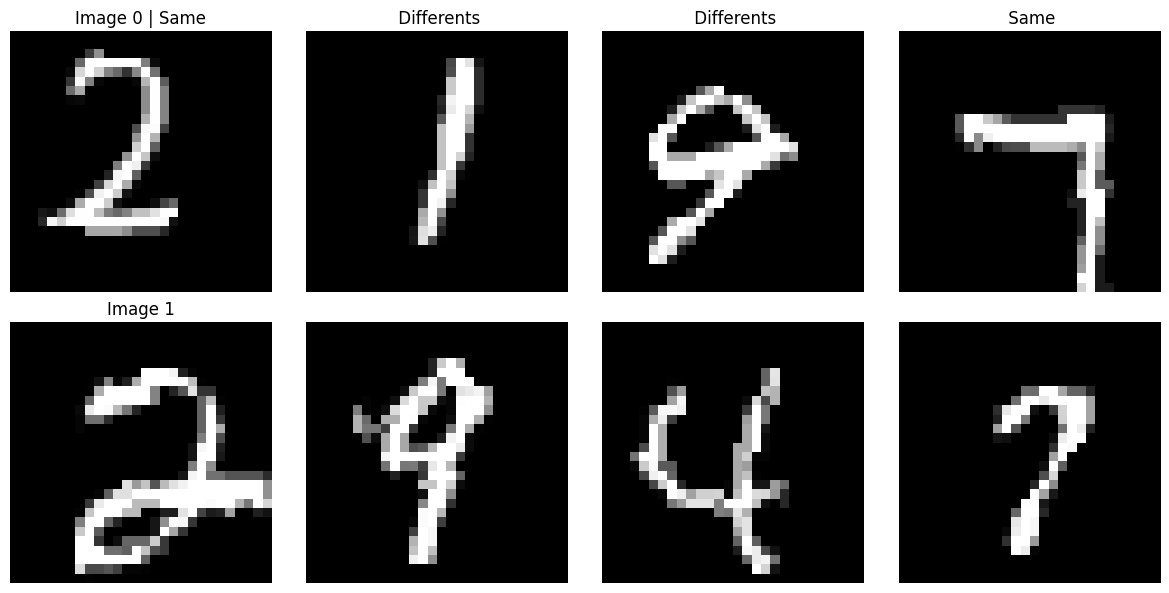

In [8]:
# Get a batch from the 'train' dataloader
image0, image1, y = next(iter(dataloaders_dict['train']))

# y values
print('y:', y[0:4])

# Plot images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    # Plot the first image
    axes[0, i].imshow(image0[i, 0, ...], cmap='gray')
    axes[0, i].set_title(("Image 0 |" if i == 0 else "") + (" Differents" if y[i] else " Same"))
    axes[0, i].axis('off')

    # Plot the second image
    axes[1, i].imshow(image1[i, 0, ...], cmap='gray')
    axes[1, i].set_title("Image 1" if i == 0 else "")
    axes[1, i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

**Q2** To separate the small images in the latent space, we will penalize discrepancies when the digit is the same and penalize proximity when the digit is different.
The notion of proximity needs clarification. [Historically](https://proceedings.neurips.cc/paper/1993/file/288cc0ff022877bd3df94bc9360b9c5d-Paper.pdf), cosine similarity was first used.
How is this similarity defined?

Complete the following cost function.

In [9]:
class ContrastiveCos(nn.Module):
    def __init__(self, margin=0.):
        super(ContrastiveCos, self).__init__()
        self.margin = margin
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-08)

    def forward(self, output0, output1, y):
        # Calculate cosine similarity
        cos_similarity = self.cos(output0, output1)

        # Contrastive loss calculation
        # case (y=1), images from different classes (minimize similarity)
        positive_loss = y * torch.relu(cos_similarity - self.margin)
        # case (y=0), images from the same class (maximize similarity)
        negative_loss = (1 - y) * torch.relu(1 - cos_similarity)
        losses = positive_loss + negative_loss

        # Calculate the mean of the losses
        return losses.mean()

loss_fn = ContrastiveCos(margin=0.5)

**Q3** Define a small CNN and train it with this loss function for ten epochs.

In [10]:
N = 490

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        ### BEGIN SOLUTION
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        ### END SOLUTION
        return x

# Move the model to the current device
model = CNN().to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [11]:
from tqdm import tqdm, notebook

num_epochs = 10
losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}')

    for phase in ['train', 'val']:
        model.train() if phase == 'train' else model.eval()

        running_loss = 0.

        # Use tqdm for progress tracking
        data_loader = notebook.tqdm(dataloaders_dict[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave=phase=='train')

        for x0, x1, y in data_loader:
            x0, x1, y = x0.to(device), x1.to(device), y.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                ### BEGIN SOLUTION
                output0 = model(x0)
                output1 = model(x1)
                loss = loss_fn(output0, output1, y)
                ### END SOLUTION
                if phase == 'train':
                    # Compute gradient and update model's parameters
                    ### BEGIN SOLUTION
                    loss.backward()
                    optimizer.step()
                    ### END SOLUTION
                running_loss += loss.item() * x0.shape[0]

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / len(datasets_dict[phase])
        losses[phase].append(epoch_loss)
        print(f'{phase} Loss: {epoch_loss:.4f}')


Epoch: 1


Train Epoch 0:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.1271


Val Epoch 0:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0630
Epoch: 2


Train Epoch 1:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0629


Val Epoch 1:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0430
Epoch: 3


Train Epoch 2:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0544


Val Epoch 2:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0478
Epoch: 4


Train Epoch 3:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0530


Val Epoch 3:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0353
Epoch: 5


Train Epoch 4:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0475


Val Epoch 4:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0362
Epoch: 6


Train Epoch 5:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0470


Val Epoch 5:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0430
Epoch: 7


Train Epoch 6:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0519


Val Epoch 6:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0476
Epoch: 8


Train Epoch 7:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0500


Val Epoch 7:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0369
Epoch: 9


Train Epoch 8:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0471


Val Epoch 8:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0418
Epoch: 10


Train Epoch 9:   0%|          | 0/844 [00:00<?, ?it/s]

train Loss: 0.0475


Val Epoch 9:   0%|          | 0/94 [00:00<?, ?it/s]

val Loss: 0.0373


**Q4** Visualize results and comment.

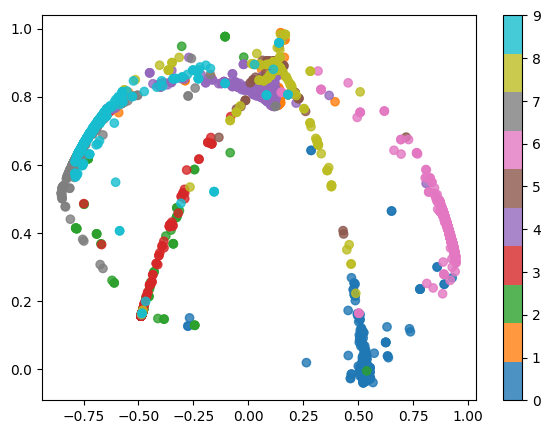

In [12]:
outputs = []
labels = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation during evaluation
    for image, label in dataloaders_dict['test']:
        ### BEGIN SOLUTION
        image = image.to(device)
        output = model(image).cpu().detach()
        ### END SOLUTION
        output = F.normalize(output, p=2.0, dim=1, eps=1e-12)
        outputs.append(output)
        labels.append(label)

labels = torch.cat(labels)
outputs = torch.cat(outputs)
# Sort outputs according to true labels
sorted_indices = np.argsort(labels)
labels = labels[sorted_indices]
# Reorganize the outputs based on labels
outputs = outputs[sorted_indices]

fig, ax = plt.subplots(figsize=(7, 5))
scatter = ax.scatter(outputs.numpy()[:, 0], outputs.numpy()[:, 2], c=labels.numpy(), cmap='tab10', alpha=0.8)
fig.colorbar(scatter)


**Q5** Using the *sim_matrix* function, visualize the distance matrix between test outputs. What accuracy can be achieved at best on a classification task?

In [13]:
def sim_matrix(a, b, eps=1e-8):
    """
    Compute the similarity matrix between two matrices.

    Args:
        a (torch.Tensor): First input matrix.
        b (torch.Tensor): Second input matrix.
        eps (float): Small value for numerical stability.

    Returns:
        torch.Tensor: Similarity matrix.
    """
    # 1) Normalize
    a_norm, b_norm = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_normalized = a / torch.max(a_norm, eps * torch.ones_like(a_norm))
    b_normalized = b / torch.max(b_norm, eps * torch.ones_like(b_norm))

    # 2) Compute the product X * tX
    sim_matrix = torch.matmul(a_normalized, b_normalized.transpose(0, 1))
    return sim_matrix

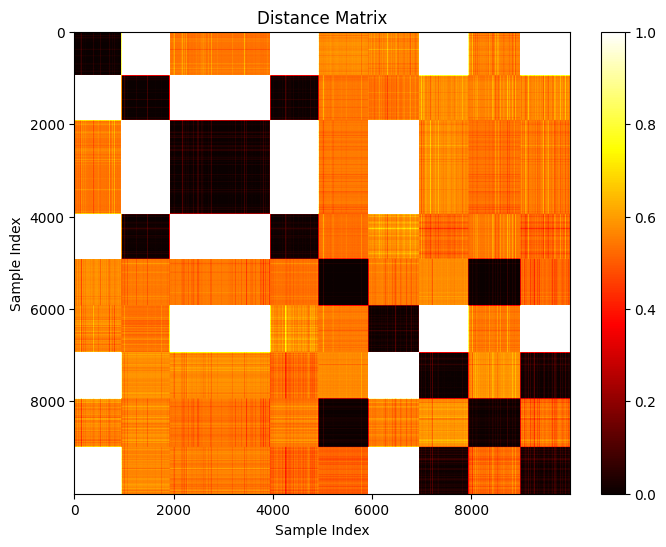

In [14]:
# Calculate the distance matrix
distances = 1 - sim_matrix(outputs, outputs)

# Plot the distance matrix
plt.figure(figsize=(8, 6))
threshold = 0.5  # Set the threshold for visualization
binary_distances = 1*(distances > threshold)

plt.imshow(distances, vmin=0., vmax=1.,cmap='hot', aspect='auto')  # 'aspect' ensures proper aspect ratio
#plt.imshow(binary_distances, vmin=0., vmax=1.,cmap='hot', aspect='auto')  # 'aspect' ensures proper aspect ratio

plt.colorbar()

# Add title and labels
plt.title('Distance Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')

# Display the plot
plt.show()


In [15]:
correct_predictions = 0
threshold = 0.1
binary_distances = distances < threshold
for label in range(10):
    # submatrix indices
    sub_ind = labels==label
    correct_predictions += binary_distances[sub_ind,:][:,sub_ind].sum().item()**0.5
accuracy = correct_predictions / len(labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 97.62%


In [16]:
thresholds = np.linspace(0.1,0.5,10)
for threshold in thresholds:
    binary_distances = distances < threshold
    correct_predictions = 0
    for label in range(10):
        # submatrix indices
        sub_ind = labels==label
        correct_predictions += binary_distances[sub_ind,:][:,sub_ind].sum().item()**0.5
    accuracy = correct_predictions / len(labels)
    print('Threshold :  {:.4f}'.format(threshold))
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print("----------------")

Threshold :  0.1000
Accuracy: 97.62%
----------------
Threshold :  0.1444
Accuracy: 98.10%
----------------
Threshold :  0.1889
Accuracy: 98.44%
----------------
Threshold :  0.2333
Accuracy: 98.68%
----------------
Threshold :  0.2778
Accuracy: 98.94%
----------------
Threshold :  0.3222
Accuracy: 99.12%
----------------
Threshold :  0.3667
Accuracy: 99.28%
----------------
Threshold :  0.4111
Accuracy: 99.33%
----------------
Threshold :  0.4556
Accuracy: 99.40%
----------------
Threshold :  0.5000
Accuracy: 99.46%
----------------


**Exercise #2**

On datasets more complex than MNIST, a simple idea has significantly enhanced separation in the "latent space." The concept involves not sampling pairs of images but rather [triplets](https://arxiv.org/pdf/1503.03832.pdf). In these triplets, we ensure that two images feature the same object (the "anchor" image and the "positive" image), while the third one contains a different object (the "negative" image). In the simplest form, the contrastive loss is applied simultaneously to the pairs (anchor, positive) and (anchor, negative).

The illustrated version here corresponds to this approach.

**Q1** Complete the DigitTripletDataset class to be able to generate a triplet (anchor, positive, negative). Visualize.

In [17]:
# For generating pairs
class DigitTripletDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.class_sizes = {}
        for i in range(10):
            self.class_sizes[i] = data_dict[i].shape[0]
        self.transform = transform

    def __getitem__(self, _):
        # Randomly choose if the pair is from the same digit (y=0) or different digits (y=1)
        y = torch.randint(0, 2, (1,)).item()

        # Randomly select two different digits
        two_digits = torch.multinomial(torch.ones(10), 2)
        digit = two_digits[0].item()
        different_digit = two_digits[1].item()

        # Randomly select images from the chosen digit
        idx_0 = np.random.randint(0, self.class_sizes[digit] - 1)
        anchor_image = self.data_dict[digit][idx_0]
        # Select positive and negative images
        ### BEGIN SOLUTION
        idx_1 = np.random.randint(0, self.class_sizes[digit] - 1)
        positive_image = self.data_dict[digit][idx_1]

        idx_2 = np.random.randint(0, self.class_sizes[different_digit] - 1)
        negative_image = self.data_dict[different_digit][idx_2]
        ### END SOLUTION
        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

    def __len__(self):
        length = 0
        for i in range(10):
            length += self.class_sizes[i]
        return  length

In [18]:
# Update the dataloaders
batch_size = 64
for phase in ['train','val']:
    datasets_dict[phase] = DigitTripletDataset(data[phase], transforms_dict[phase])
    dataloaders_dict[phase] = DataLoader(datasets_dict[phase], shuffle = True, batch_size=batch_size, num_workers=2)

y: tensor([1, 0, 0, 0], device='cuda:0')


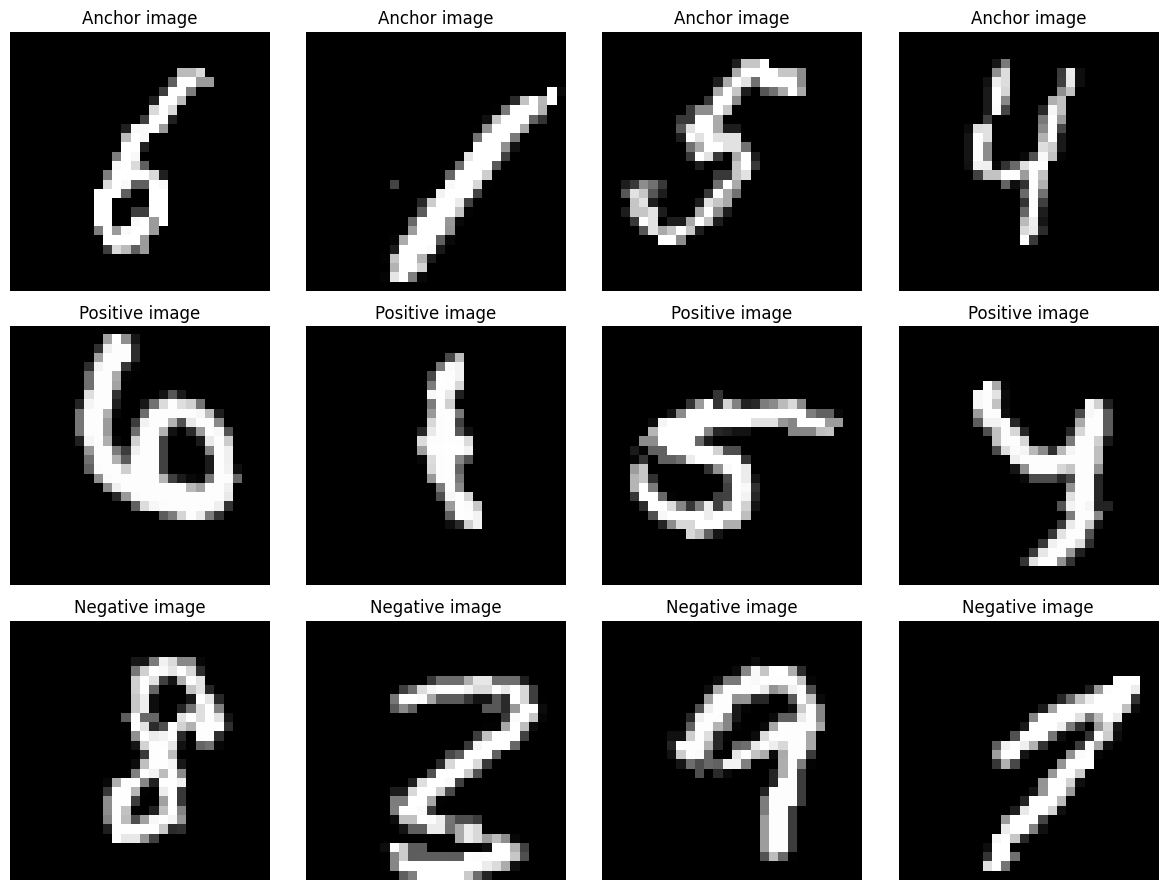

In [19]:
# Get a batch from the 'train' dataloader
anchor, positive, negative = next(iter(dataloaders_dict['train']))

# y values
print('y:', y[0:4])

# Plot images
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i in range(4):
    # Plot the anchor image
    axes[0, i].imshow(anchor[i, 0, ...], cmap='gray')
    axes[0, i].set_title("Anchor image")
    axes[0, i].axis('off')

    # Plot the positive image
    axes[1, i].imshow(positive[i, 0, ...], cmap='gray')
    axes[1, i].set_title("Positive image")
    axes[1, i].axis('off')

    # Plot the negative image
    axes[2, i].imshow(negative[i, 0, ...], cmap='gray')
    axes[2, i].set_title("Negative image")
    axes[2, i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

**Q2** Complete the definition of the triplet loss.

In [20]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-08)


    def forward(self, anchor, positive, negative):
        cosap = self.cos(anchor, positive)
        cosan = self.cos(anchor, negative)
        losses = torch.relu((1 - cosap) - (1 - cosan) + self.margin)

        return losses.mean()

loss_fn = TripletLoss(0.2)

**Q3** Entraîner le même modèle que dans l'exercice n°2 et comparer les performances.

In [21]:
model = CNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [22]:
num_epochs = 10
losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}')

    for phase in ['train', 'val']:
        model.train() if phase == 'train' else model.eval()

        running_loss = 0.

        # Use tqdm for progress tracking
        data_loader = notebook.tqdm(dataloaders_dict[phase], desc=f'{phase.capitalize()} Epoch {epoch}', leave=phase=='train')

        for anchor, positive, negative in data_loader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                ### BEGIN SOLUTION
                anchor_output = model(anchor)
                positive_output = model(positive)
                negative_output = model(negative)

                loss = loss_fn(anchor_output, positive_output, negative_output)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                ### END SOLUTION
                running_loss += loss.item() * x0.shape[0]

            data_loader.set_postfix(loss=f'{loss.item():.4f}', refresh=False)

        epoch_loss = running_loss / len(datasets_dict[phase])
        losses[phase].append(epoch_loss)
        print(f'{phase} Loss: {epoch_loss:.4f}')

Epoch: 1


Train Epoch 0:   0%|          | 0/844 [00:00<?, ?it/s]

KeyboardInterrupt: 

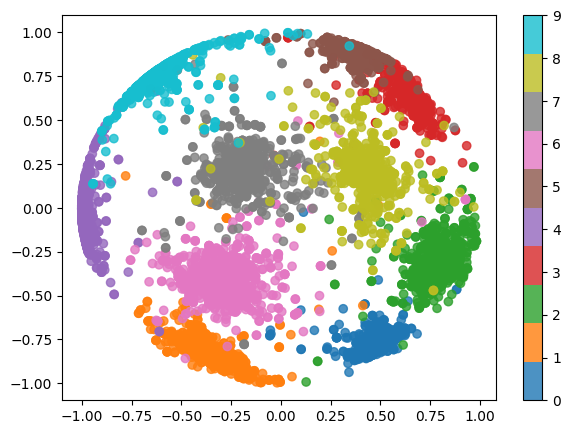

In [ ]:
outputs = []
labels = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation during evaluation
    for image, label in dataloaders_dict['test']:
        ### BEGIN SOLUTION
        image = image.to(device)
        output = model(image).cpu().detach()
        ### END SOLUTION
        output = F.normalize(output, p=2.0, dim=1, eps=1e-12)
        outputs.append(output)
        labels.append(label)

labels = torch.cat(labels)
outputs = torch.cat(outputs)
# Sort outputs according to true labels
sorted_indices = np.argsort(labels)
labels = labels[sorted_indices]
# Reorganize the outputs based on labels
outputs = outputs[sorted_indices]

fig, ax = plt.subplots(figsize=(7, 5))
scatter = ax.scatter(outputs.numpy()[:, 0], outputs.numpy()[:, 2], c=labels.numpy(), cmap='tab10', alpha=0.8)
fig.colorbar(scatter)

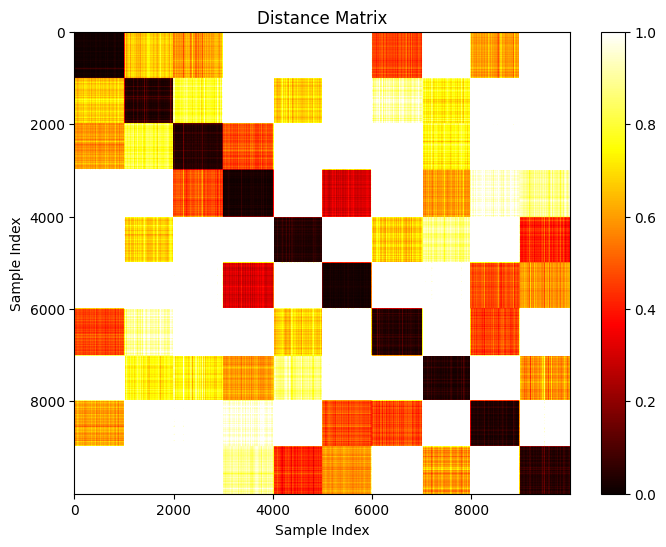

In [ ]:
# Calculate the distance matrix
distances = 1 - sim_matrix(outputs, outputs)

# Plot the distance matrix
plt.figure(figsize=(8, 6))
threshold = 0.5  # Set the threshold for visualization
binary_distances = 1*(distances > threshold)

plt.imshow(distances, vmin=0., vmax=1.,cmap='hot', aspect='auto')  # 'aspect' ensures proper aspect ratio
#plt.imshow(binary_distances, vmin=0., vmax=1.,cmap='hot', aspect='auto')  # 'aspect' ensures proper aspect ratio

plt.colorbar()

# Add title and labels
plt.title('Distance Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')

# Display the plot
plt.show()

In [ ]:
thresholds = np.linspace(0.1,0.55,10)
for threshold in thresholds:
    binary_distances = distances < threshold
    correct_predictions = 0
    for label in range(10):
        # submatrix indices
        sub_ind = labels==label
        correct_predictions += binary_distances[sub_ind,:][:,sub_ind].sum().item()**0.5
    accuracy = correct_predictions / len(labels)
    print('Threshold :  {:.4f}'.format(threshold))
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print("----------------")

Threshold :  0.1000
Accuracy: 95.47%
----------------
Threshold :  0.1500
Accuracy: 97.30%
----------------
Threshold :  0.2000
Accuracy: 98.14%
----------------
Threshold :  0.2500
Accuracy: 98.64%
----------------
Threshold :  0.3000
Accuracy: 99.01%
----------------
Threshold :  0.3500
Accuracy: 99.25%
----------------
Threshold :  0.4000
Accuracy: 99.43%
----------------
Threshold :  0.4500
Accuracy: 99.56%
----------------
Threshold :  0.5000
Accuracy: 99.66%
----------------
Threshold :  0.5500
Accuracy: 99.74%
----------------


Extensions:
- Triplet mining
- [Self-supervised approaches](https://arxiv.org/pdf/2002.05709.pdf)
- [re-identification](https://arxiv.org/pdf/2001.04193.pdf)